<a href="https://colab.research.google.com/github/minit88/ML-DL/blob/main/Lab_10/1_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
 # convoluiton : 이미지 위에서 strdie 값 만큼 filter을 이동시키면서 겹쳐지는 부분의 각 원소의 값을 곱해서 모두 더한 값을 출력하는 연산
 # stride : filter를 한번에 얼마나 이동 할 것인가
 # padding : zoer-padding(0의 띠가 둘러진다고 생각)
 
 # convolution의 output크기 
 # output = {input_size - filter_size+(2*padding)}/stride +1
 # 컨벌루션 연산은 커널 또는 필터라는 n x m 크기의 행렬로

 # 이미지는 3차원 벡터행렬로 ( 높이 ,너비,깊이)
 # 높이 x 너비 크기의 이미지를 처음부터 끝까지 겹치며 훑으면서 n x m 크기의 겹쳐지는 부분의 각 이미지와 커널의 원소의 값을 곱해서 모두 더한 값을 출력으로 하는 것을 말합니다.
 # 이때, 이미지의 가장 왼쪽 위부터 가장 오른쪽까지 순차적으로 훑습니다.
 # 합성곱 연산을 통해 나온 결과를 특성 맵
 


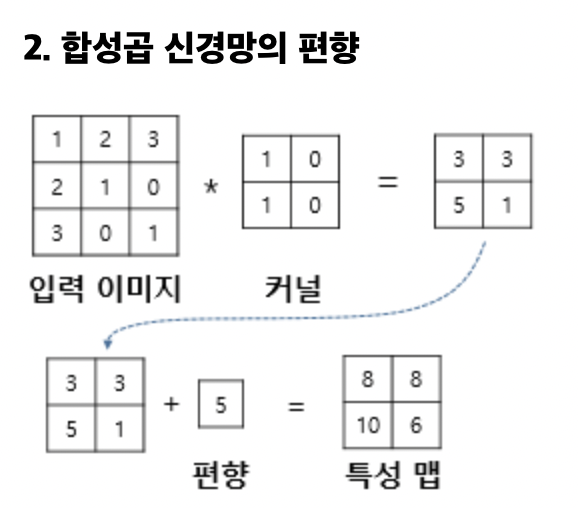

In [18]:
import torch
import torch.nn as nn
# input = 1x28x28
# filter = 5x5x5
# conv1 = 5x24x24
# pool1 = 5x12x12
# output = 5x12x12
inputs = torch.Tensor(1,1,28,28)
conv1 = nn.Conv2d(1,5,5)
pool = nn.MaxPool2d(2) # 2x2 
out = conv1(inputs)
out2 = pool(out)
out.size()
out2.size()

torch.Size([1, 5, 12, 12])

In [19]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [21]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [22]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [23]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [24]:
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [33]:
model = CNN().to(device)
params = list(CNN().parameters())
print(len(params))
print(params[0].size())  # conv1의 .weight

6
torch.Size([32, 1, 3, 3])


In [26]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
# train my model
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.225628644
[Epoch:    2] cost = 0.0630425066
[Epoch:    3] cost = 0.046389699
[Epoch:    4] cost = 0.0374845006
[Epoch:    5] cost = 0.031433057
[Epoch:    6] cost = 0.0261363648
[Epoch:    7] cost = 0.022024285
[Epoch:    8] cost = 0.0183657762
[Epoch:    9] cost = 0.0162043925
[Epoch:   10] cost = 0.0134079289
[Epoch:   11] cost = 0.0102126868
[Epoch:   12] cost = 0.00976756122
[Epoch:   13] cost = 0.00878930092
[Epoch:   14] cost = 0.00629561162
[Epoch:   15] cost = 0.00555317383
Learning Finished!


In [28]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9873999953269958
